In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,  Dataset
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from torch.utils.tensorboard import SummaryWriter
import datetime

import open3d as o3d
import os
import warnings
from tqdm import tqdm
import pandas as pd
from pathlib import Path

warnings.filterwarnings("ignore")
o3d.utility.set_verbosity_level(o3d.utility.VerbosityLevel.Error)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
log_dir = "runs/pointnet_experiment_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
writer = SummaryWriter(log_dir)

print(f"TensorBoard log directory: {log_dir}")

TensorBoard log directory: runs/pointnet_experiment_20260103-153840


In [3]:
ROOT = os.getcwd()
DATA_PATH = os.path.join(ROOT, "..", "data", "raw","ModelNet40")
DATA_PATH_ABS = os.path.abspath(DATA_PATH)

DATA_CSV = os.path.join(ROOT, "..", "data", "raw", "metadata_modelnet40.csv")
DATA_CSV = os.path.abspath(DATA_CSV)

In [4]:
class_name = []
for fol in sorted(os.listdir(DATA_PATH_ABS)):
    fol_path = os.path.join(DATA_PATH_ABS, fol)
    
    if not os.path.isdir(fol_path):
        continue

    train_path = os.path.join(fol_path, "train")
    
    if os.path.exists(train_path):
        files = os.listdir(train_path)
        off_files = [f for f in files if f.endswith('.off')] 
        
        print(f"{fol:<20} | {len(off_files)}")
        class_name.append(fol)

airplane             | 626
bathtub              | 106
bed                  | 515
bench                | 173
bookshelf            | 572
bottle               | 335
bowl                 | 64
car                  | 197
chair                | 889
cone                 | 167
cup                  | 79
curtain              | 138
desk                 | 200
door                 | 109
dresser              | 200
flower_pot           | 149
glass_box            | 171
guitar               | 155
keyboard             | 145
lamp                 | 124
laptop               | 149
mantel               | 284
monitor              | 465
night_stand          | 200
person               | 88
piano                | 231
plant                | 240
radio                | 104
range_hood           | 115
sink                 | 128
sofa                 | 680
stairs               | 124
stool                | 90
table                | 392
tent                 | 163
toilet               | 344
tv_stand             | 267
vase 

## Trying visaulize

In [5]:
def read_off_with_open3d(file_path, num_points=1024):
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None
        
    mesh = o3d.io.read_triangle_mesh(file_path)
    pcd = mesh.sample_points_uniformly(number_of_points=num_points)
    o3d.visualization.draw_geometries([mesh], window_name="ModelNet40 Preview")
    print(pcd)
    return mesh

In [6]:
example_path = os.path.join(DATA_PATH_ABS, "airplane", "train", "airplane_0004.off")
mesh = read_off_with_open3d(example_path)
print(mesh)

PointCloud with 1024 points.
TriangleMesh with 58194 points and 75957 triangles.


In [7]:
# def is_valid_off_file(file_path, num_points=1024):
#     try:
#         with open(file_path, 'r') as f:
#             header = f.readline().strip()
#             if not header.startswith('OFF'):
#                 return False

#         mesh = o3d.io.read_triangle_mesh(str(file_path))
        
#         if not mesh.has_vertices() or not mesh.has_triangles():
#             return False
            
#         return True
#     except Exception:
#         return False

In [8]:
# all_files = list(Path(DATA_PATH).rglob('*.off'))

# data = []
# for file_path in tqdm(all_files, desc="Processing paths"):
    
#     if not is_valid_off_file(str(file_path)):
#         continue
        
#     data.append({
#         'path': str(file_path),
#         'category': file_path.parts[-3],
#         'original_split': file_path.parts[-2]
#     })

# df = pd.DataFrame(data)

# cat_to_idx = {cat: i for i, cat in enumerate(sorted(df['category'].unique()))}
# df['label'] = df['category'].map(cat_to_idx)

# print(df.head())

In [9]:
df = pd.read_csv(DATA_CSV)

In [10]:
df['object_path'] = df['object_path'].apply(lambda x: os.path.join(DATA_PATH, str(x)))

In [11]:
df['object_path'][0]

'c:\\Users\\babxk\\Documents\\GitHub\\ModelNet\\notebook\\..\\data\\raw\\ModelNet40\\airplane/test/airplane_0627.off'

In [12]:

classes = sorted(df['class'].unique())
cat_to_idx = {cat: i for i, cat in enumerate(classes)}

df['label'] = df['class'].map(cat_to_idx)


test_df = df[df['split'] == 'test'].copy()
train_full_df = df[df['split'] == 'train'].copy()

from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    train_full_df, 
    test_size=0.2, 
    stratify=train_full_df['label'], 
    random_state=42
)

train_paths = train_df['object_path'].tolist()
train_labels = train_df['label'].tolist()  

val_paths = val_df['object_path'].tolist()
val_labels = val_df['label'].tolist()      

test_paths = test_df['object_path'].tolist()
test_labels = test_df['label'].tolist()    #

print(f"Train Labels Example: {train_labels[:5]}") 

Train Labels Example: [9, 3, 8, 8, 20]


In [13]:
class PCD(Dataset):
    def __init__(self, file_paths, labels, num_points=1024, train=True):
        """
        Args:
            train (bool): ถ้า True จะเปิดใช้ Data Augmentation (หมุน/สั่นภาพ)
        """
        self.file_paths = file_paths
        self.labels = labels
        self.num_points = num_points
        self.train = train 

        self.data_points = []
        self.valid_labels = []
        
        print(f"Loading {len(file_paths)} files ({'Train' if train else 'Test/Val'})...")
        for i, path in enumerate(tqdm(file_paths)):
            try:
                mesh = o3d.io.read_triangle_mesh(path)
                
                pcd = mesh.sample_points_uniformly(number_of_points=num_points)
                points = np.asarray(pcd.points)
                
                points = self.pc_normalize(points)
                
                self.data_points.append(points)
                self.valid_labels.append(labels[i])
            except Exception as e:
                continue
            
    def pc_normalize(self, pc):
        """ ปรับจุดให้อยู่ในทรงกลมรัศมี 1 (Unit Sphere) """
        centroid = np.mean(pc, axis=0)
        pc = pc - centroid
        m = np.max(np.sqrt(np.sum(pc**2, axis=1)))
        pc = pc / m
        return pc
    
    def random_rotate(self, pc):
        """ หมุน Point Cloud รอบแกน Y """
        angle = np.random.uniform() * 2 * np.pi
        cosval, sinval = np.cos(angle), np.sin(angle)
        rotation_matrix = np.array([[cosval, 0, sinval],
                                    [0, 1, 0],
                                    [-sinval, 0, cosval]])
        return np.dot(pc, rotation_matrix).astype(np.float32)

    def jitter(self, pc, sigma=0.01, clip=0.05):
        """ ใส่ Noise ให้จุดขยับ"""
        N, C = pc.shape
        noise = np.clip(sigma * np.random.randn(N, C), -1*clip, clip)
        return pc + noise

    def __len__(self):
        return len(self.valid_labels)
    
    def __getitem__(self, idx):
        points = self.data_points[idx].copy()
        label = self.valid_labels[idx]
        
        if self.train:
            points = self.random_rotate(points)
            points = self.jitter(points)
        
        return torch.tensor(points, dtype=torch.float32).transpose(1, 0), torch.tensor(label, dtype=torch.long)

In [14]:
batch_size = 32
train_dataset = PCD(train_paths, train_labels)
val_dataset = PCD(val_paths, val_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Loading 7874 files (Train)...


100%|██████████| 7874/7874 [10:35<00:00, 12.40it/s]  


Loading 1969 files (Train)...


100%|██████████| 1969/1969 [02:57<00:00, 11.12it/s]


In [15]:
data_iter = iter(train_loader)
points, labels = next(data_iter)

In [33]:
class STN3d(nn.Module):
    """ T-Net ตัวแรก: สำหรับหมุน Input Point Cloud (3x3) """
    def __init__(self):
        super(STN3d, self).__init__()
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

    def forward(self, x):
        batchsize = x.size(0)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = torch.from_numpy(np.eye(3).flatten().astype(np.float32)).view(1,9).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, 3, 3)
        return x

In [34]:
class STNkd(nn.Module):
    """ T-Net ตัวที่สอง: สำหรับหมุน Feature (k x k) ปกติ k=64 """
    def __init__(self, k=64):
        super(STNkd, self).__init__()
        self.conv1 = torch.nn.Conv1d(k, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k*k)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)
        self.k = k

    def forward(self, x):
        batchsize = x.size(0)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = torch.from_numpy(np.eye(self.k).flatten().astype(np.float32)).view(1,self.k*self.k).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, self.k, self.k)
        return x

In [35]:
class PointNetFull(nn.Module):
    def __init__(self, num_classes=40):
        super(PointNetFull, self).__init__()
        
        self.stn = STN3d()
        
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 64, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.fstn = STNkd(k=64)
        
        self.conv3 = torch.nn.Conv1d(64, 64, 1)
        self.conv4 = torch.nn.Conv1d(64, 128, 1)
        self.conv5 = torch.nn.Conv1d(128, 1024, 1)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(1024)
        
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(p=0.3)
        self.bn6 = nn.BatchNorm1d(512)
        self.bn7 = nn.BatchNorm1d(256)

    def forward(self, x):
        B, D, N = x.size()
        
        trans = self.stn(x)
        x = x.transpose(2, 1) 
        x = torch.bmm(x, trans) #
        x = x.transpose(2, 1)
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        
        trans_feat = self.fstn(x)
        x = x.transpose(2, 1)
        x = torch.bmm(x, trans_feat) 
        x = x.transpose(2, 1)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn6(self.fc1(x)))
        x = F.relu(self.bn7(self.dropout(self.fc2(x))))
        x = self.fc3(x)
        
        return x, trans_feat

In [36]:
num_classes = 40
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PointNetFull(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [37]:
def feature_transform_regularizer(trans):
    d = trans.size()[1]
    I = torch.eye(d)[None, :, :]
    if trans.is_cuda:
        I = I.cuda()
    loss = torch.mean(torch.norm(torch.bmm(trans, trans.transpose(2,1)) - I, dim=(1,2)))
    return loss

def get_loss(pred, target, trans_feat, mat_diff_loss_scale=0.001):
    loss_cls = F.cross_entropy(pred, target)
    
    loss_reg = feature_transform_regularizer(trans_feat)
    
    total_loss = loss_cls + (mat_diff_loss_scale * loss_reg)
    return total_loss

In [22]:
for epoch in range(200):
    model.train()
    running_loss = 0.0
    correct = 0

    for point_clouds, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        point_clouds, labels = point_clouds.to(device), labels.to(device)

        optimizer.zero_grad()
        
        outputs, trans_feat = model(point_clouds) 
        
        loss = get_loss(outputs, labels, trans_feat)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / len(train_dataset)
    
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc * 100, epoch)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    
    with torch.no_grad():
        for point_clouds, labels in val_loader:
            point_clouds, labels = point_clouds.to(device), labels.to(device)
            outputs, trans_feat = model(point_clouds)
            
            loss = get_loss(outputs, labels, trans_feat) 
            val_loss += loss.item()
            
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            
    val_epoch_loss = val_loss / len(val_loader)
    val_epoch_acc = val_correct / len(val_dataset)

    writer.add_scalar('Loss/val', val_epoch_loss, epoch)
    writer.add_scalar('Accuracy/val', val_epoch_acc * 100, epoch)
    
    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Acc: {train_acc*100:.2f}% | Val Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc*100:.2f}%")

writer.close()

Epoch 1: 100%|██████████| 173/173 [00:34<00:00,  5.06it/s]


Epoch 1 - Train Loss: 2.4247, Acc: 38.98% | Val Loss: 2.0824, Acc: 44.74%


Epoch 2: 100%|██████████| 173/173 [00:19<00:00,  8.97it/s]


Epoch 2 - Train Loss: 1.8561, Acc: 49.11% | Val Loss: 2.0962, Acc: 45.32%


Epoch 3: 100%|██████████| 173/173 [00:19<00:00,  8.88it/s]


Epoch 3 - Train Loss: 1.7074, Acc: 51.78% | Val Loss: 1.4782, Acc: 58.59%


Epoch 4: 100%|██████████| 173/173 [00:19<00:00,  8.79it/s]


Epoch 4 - Train Loss: 1.4980, Acc: 56.54% | Val Loss: 1.6024, Acc: 56.71%


Epoch 5: 100%|██████████| 173/173 [00:19<00:00,  9.00it/s]


Epoch 5 - Train Loss: 1.4100, Acc: 59.71% | Val Loss: 1.5012, Acc: 57.36%


Epoch 6: 100%|██████████| 173/173 [00:19<00:00,  8.99it/s]


Epoch 6 - Train Loss: 1.3998, Acc: 58.90% | Val Loss: 1.3451, Acc: 63.09%


Epoch 7: 100%|██████████| 173/173 [00:19<00:00,  9.01it/s]


Epoch 7 - Train Loss: 1.2050, Acc: 64.87% | Val Loss: 1.5875, Acc: 57.94%


Epoch 8: 100%|██████████| 173/173 [00:19<00:00,  9.01it/s]


Epoch 8 - Train Loss: 1.1901, Acc: 64.69% | Val Loss: 1.1753, Acc: 68.38%


Epoch 9: 100%|██████████| 173/173 [00:19<00:00,  9.00it/s]


Epoch 9 - Train Loss: 1.1348, Acc: 66.54% | Val Loss: 1.6565, Acc: 54.39%


Epoch 10: 100%|██████████| 173/173 [00:19<00:00,  9.03it/s]


Epoch 10 - Train Loss: 1.4254, Acc: 58.91% | Val Loss: 1.3041, Acc: 63.31%


Epoch 11: 100%|██████████| 173/173 [00:19<00:00,  9.00it/s]


Epoch 11 - Train Loss: 1.1283, Acc: 65.94% | Val Loss: 2.2915, Acc: 40.10%


Epoch 12: 100%|██████████| 173/173 [00:19<00:00,  9.03it/s]


Epoch 12 - Train Loss: 1.3617, Acc: 59.51% | Val Loss: 1.2058, Acc: 66.79%


Epoch 13: 100%|██████████| 173/173 [00:19<00:00,  8.94it/s]


Epoch 13 - Train Loss: 1.0989, Acc: 66.70% | Val Loss: 1.1278, Acc: 68.24%


Epoch 14: 100%|██████████| 173/173 [00:19<00:00,  8.93it/s]


Epoch 14 - Train Loss: 1.0218, Acc: 68.61% | Val Loss: 1.0345, Acc: 70.70%


Epoch 15: 100%|██████████| 173/173 [00:19<00:00,  8.91it/s]


Epoch 15 - Train Loss: 1.0322, Acc: 68.86% | Val Loss: 1.0829, Acc: 70.27%


Epoch 16: 100%|██████████| 173/173 [00:19<00:00,  8.85it/s]


Epoch 16 - Train Loss: 0.9969, Acc: 69.63% | Val Loss: 1.2530, Acc: 63.23%


Epoch 17: 100%|██████████| 173/173 [00:19<00:00,  8.89it/s]


Epoch 17 - Train Loss: 0.9886, Acc: 69.64% | Val Loss: 1.1739, Acc: 65.34%


Epoch 18: 100%|██████████| 173/173 [00:19<00:00,  8.96it/s]


Epoch 18 - Train Loss: 0.9239, Acc: 71.57% | Val Loss: 1.0598, Acc: 71.43%


Epoch 19: 100%|██████████| 173/173 [00:19<00:00,  8.89it/s]


Epoch 19 - Train Loss: 0.9091, Acc: 73.51% | Val Loss: 1.6005, Acc: 53.08%


Epoch 20: 100%|██████████| 173/173 [00:19<00:00,  8.68it/s]


Epoch 20 - Train Loss: 1.0402, Acc: 68.92% | Val Loss: 1.0605, Acc: 70.92%


Epoch 21: 100%|██████████| 173/173 [00:20<00:00,  8.60it/s]


Epoch 21 - Train Loss: 0.9345, Acc: 72.15% | Val Loss: 0.9547, Acc: 72.59%


Epoch 22: 100%|██████████| 173/173 [00:19<00:00,  8.72it/s]


Epoch 22 - Train Loss: 0.9226, Acc: 72.62% | Val Loss: 1.2254, Acc: 66.86%


Epoch 23: 100%|██████████| 173/173 [00:19<00:00,  8.87it/s]


Epoch 23 - Train Loss: 0.9534, Acc: 72.04% | Val Loss: 1.1588, Acc: 67.73%


Epoch 24: 100%|██████████| 173/173 [00:19<00:00,  8.77it/s]


Epoch 24 - Train Loss: 0.9387, Acc: 71.71% | Val Loss: 0.9149, Acc: 74.55%


Epoch 25: 100%|██████████| 173/173 [00:19<00:00,  8.94it/s]


Epoch 25 - Train Loss: 0.8972, Acc: 73.49% | Val Loss: 0.9072, Acc: 75.71%


Epoch 26: 100%|██████████| 173/173 [00:20<00:00,  8.61it/s]


Epoch 26 - Train Loss: 0.8505, Acc: 74.42% | Val Loss: 0.9243, Acc: 75.85%


Epoch 27: 100%|██████████| 173/173 [00:19<00:00,  8.98it/s]


Epoch 27 - Train Loss: 0.8205, Acc: 74.80% | Val Loss: 0.9790, Acc: 73.97%


Epoch 28: 100%|██████████| 173/173 [00:19<00:00,  8.99it/s]


Epoch 28 - Train Loss: 0.8143, Acc: 75.18% | Val Loss: 0.8308, Acc: 76.94%


Epoch 29: 100%|██████████| 173/173 [00:19<00:00,  8.99it/s]


Epoch 29 - Train Loss: 0.7930, Acc: 75.84% | Val Loss: 0.8330, Acc: 76.94%


Epoch 30: 100%|██████████| 173/173 [00:19<00:00,  8.86it/s]


Epoch 30 - Train Loss: 0.7868, Acc: 76.27% | Val Loss: 2.8102, Acc: 33.43%


Epoch 31: 100%|██████████| 173/173 [00:20<00:00,  8.54it/s]


Epoch 31 - Train Loss: 0.8428, Acc: 74.55% | Val Loss: 1.7894, Acc: 47.35%


Epoch 32: 100%|██████████| 173/173 [00:19<00:00,  8.66it/s]


Epoch 32 - Train Loss: 0.8987, Acc: 72.79% | Val Loss: 0.9509, Acc: 73.68%


Epoch 33: 100%|██████████| 173/173 [00:19<00:00,  8.93it/s]


Epoch 33 - Train Loss: 0.8316, Acc: 73.91% | Val Loss: 0.8771, Acc: 75.92%


Epoch 34: 100%|██████████| 173/173 [00:19<00:00,  9.05it/s]


Epoch 34 - Train Loss: 0.7719, Acc: 76.00% | Val Loss: 0.9317, Acc: 73.97%


Epoch 35: 100%|██████████| 173/173 [00:19<00:00,  8.85it/s]


Epoch 35 - Train Loss: 0.8061, Acc: 74.71% | Val Loss: 0.9565, Acc: 72.88%


Epoch 36: 100%|██████████| 173/173 [00:20<00:00,  8.52it/s]


Epoch 36 - Train Loss: 0.7419, Acc: 77.12% | Val Loss: 0.8260, Acc: 75.92%


Epoch 37: 100%|██████████| 173/173 [00:19<00:00,  9.00it/s]


Epoch 37 - Train Loss: 0.8392, Acc: 74.85% | Val Loss: 0.8395, Acc: 75.20%


Epoch 38: 100%|██████████| 173/173 [00:19<00:00,  8.98it/s]


Epoch 38 - Train Loss: 0.7330, Acc: 77.74% | Val Loss: 0.8346, Acc: 76.43%


Epoch 39: 100%|██████████| 173/173 [00:19<00:00,  8.99it/s]


Epoch 39 - Train Loss: 0.7715, Acc: 76.18% | Val Loss: 0.8617, Acc: 76.72%


Epoch 40: 100%|██████████| 173/173 [00:19<00:00,  8.85it/s]


Epoch 40 - Train Loss: 0.7314, Acc: 77.58% | Val Loss: 1.4818, Acc: 59.17%


Epoch 41: 100%|██████████| 173/173 [00:19<00:00,  8.71it/s]


Epoch 41 - Train Loss: 1.0124, Acc: 69.99% | Val Loss: 0.8958, Acc: 75.34%


Epoch 42: 100%|██████████| 173/173 [00:19<00:00,  8.69it/s]


Epoch 42 - Train Loss: 0.7681, Acc: 76.33% | Val Loss: 0.9072, Acc: 75.63%


Epoch 43: 100%|██████████| 173/173 [00:19<00:00,  9.00it/s]


Epoch 43 - Train Loss: 0.7653, Acc: 77.43% | Val Loss: 0.9738, Acc: 72.88%


Epoch 44: 100%|██████████| 173/173 [00:19<00:00,  9.02it/s]


Epoch 44 - Train Loss: 0.8086, Acc: 75.53% | Val Loss: 0.8506, Acc: 77.59%


Epoch 45: 100%|██████████| 173/173 [00:19<00:00,  8.86it/s]


Epoch 45 - Train Loss: 0.6917, Acc: 78.16% | Val Loss: 0.8639, Acc: 77.81%


Epoch 46: 100%|██████████| 173/173 [00:18<00:00,  9.15it/s]


Epoch 46 - Train Loss: 0.7075, Acc: 78.90% | Val Loss: 0.8828, Acc: 74.69%


Epoch 47: 100%|██████████| 173/173 [00:20<00:00,  8.62it/s]


Epoch 47 - Train Loss: 0.6765, Acc: 78.79% | Val Loss: 0.8463, Acc: 77.96%


Epoch 48: 100%|██████████| 173/173 [00:20<00:00,  8.45it/s]


Epoch 48 - Train Loss: 0.6719, Acc: 79.68% | Val Loss: 0.7647, Acc: 78.54%


Epoch 49: 100%|██████████| 173/173 [00:19<00:00,  8.95it/s]


Epoch 49 - Train Loss: 0.7005, Acc: 78.09% | Val Loss: 0.7951, Acc: 78.61%


Epoch 50: 100%|██████████| 173/173 [00:20<00:00,  8.43it/s]


Epoch 50 - Train Loss: 0.6590, Acc: 79.88% | Val Loss: 0.7868, Acc: 78.68%


Epoch 51: 100%|██████████| 173/173 [00:20<00:00,  8.62it/s]


Epoch 51 - Train Loss: 0.8962, Acc: 73.38% | Val Loss: 0.8516, Acc: 75.34%


Epoch 52: 100%|██████████| 173/173 [00:21<00:00,  8.22it/s]


Epoch 52 - Train Loss: 0.8211, Acc: 74.84% | Val Loss: 0.8265, Acc: 76.94%


Epoch 53: 100%|██████████| 173/173 [00:20<00:00,  8.24it/s]


Epoch 53 - Train Loss: 0.7026, Acc: 78.12% | Val Loss: 0.8689, Acc: 76.58%


Epoch 54: 100%|██████████| 173/173 [00:20<00:00,  8.53it/s]


Epoch 54 - Train Loss: 0.6671, Acc: 79.68% | Val Loss: 0.9434, Acc: 72.95%


Epoch 55: 100%|██████████| 173/173 [00:20<00:00,  8.44it/s]


Epoch 55 - Train Loss: 0.6751, Acc: 79.21% | Val Loss: 0.7601, Acc: 78.68%


Epoch 56: 100%|██████████| 173/173 [00:20<00:00,  8.49it/s]


Epoch 56 - Train Loss: 0.6404, Acc: 80.25% | Val Loss: 0.8264, Acc: 78.46%


Epoch 57: 100%|██████████| 173/173 [00:19<00:00,  8.68it/s]


Epoch 57 - Train Loss: 0.6513, Acc: 79.96% | Val Loss: 0.7573, Acc: 79.77%


Epoch 58: 100%|██████████| 173/173 [00:19<00:00,  8.75it/s]


Epoch 58 - Train Loss: 0.6512, Acc: 79.70% | Val Loss: 0.7365, Acc: 79.99%


Epoch 59: 100%|██████████| 173/173 [00:19<00:00,  8.85it/s]


Epoch 59 - Train Loss: 0.6122, Acc: 80.50% | Val Loss: 0.8496, Acc: 77.52%


Epoch 60: 100%|██████████| 173/173 [00:19<00:00,  8.80it/s]


Epoch 60 - Train Loss: 0.7068, Acc: 77.36% | Val Loss: 0.7248, Acc: 79.26%


Epoch 61: 100%|██████████| 173/173 [00:21<00:00,  8.16it/s]


Epoch 61 - Train Loss: 0.6373, Acc: 80.46% | Val Loss: 0.7696, Acc: 79.33%


Epoch 62: 100%|██████████| 173/173 [00:20<00:00,  8.44it/s]


Epoch 62 - Train Loss: 0.6375, Acc: 80.07% | Val Loss: 0.8126, Acc: 78.32%


Epoch 63: 100%|██████████| 173/173 [00:21<00:00,  8.19it/s]


Epoch 63 - Train Loss: 0.7056, Acc: 78.34% | Val Loss: 0.8034, Acc: 78.32%


Epoch 64: 100%|██████████| 173/173 [00:20<00:00,  8.57it/s]


Epoch 64 - Train Loss: 0.6703, Acc: 79.07% | Val Loss: 0.7830, Acc: 79.33%


Epoch 65: 100%|██████████| 173/173 [00:19<00:00,  8.65it/s]


Epoch 65 - Train Loss: 0.6086, Acc: 81.41% | Val Loss: 0.7123, Acc: 80.78%


Epoch 66: 100%|██████████| 173/173 [00:20<00:00,  8.49it/s]


Epoch 66 - Train Loss: 0.6206, Acc: 80.37% | Val Loss: 0.7573, Acc: 78.46%


Epoch 67: 100%|██████████| 173/173 [00:19<00:00,  9.02it/s]


Epoch 67 - Train Loss: 0.5829, Acc: 81.52% | Val Loss: 0.8179, Acc: 77.74%


Epoch 68: 100%|██████████| 173/173 [00:19<00:00,  8.98it/s]


Epoch 68 - Train Loss: 0.5711, Acc: 82.12% | Val Loss: 0.7347, Acc: 80.13%


Epoch 69: 100%|██████████| 173/173 [00:19<00:00,  9.02it/s]


Epoch 69 - Train Loss: 0.6176, Acc: 81.10% | Val Loss: 0.8005, Acc: 77.81%


Epoch 70: 100%|██████████| 173/173 [00:20<00:00,  8.58it/s]


Epoch 70 - Train Loss: 0.6017, Acc: 80.63% | Val Loss: 0.6833, Acc: 81.87%


Epoch 71: 100%|██████████| 173/173 [00:19<00:00,  9.06it/s]


Epoch 71 - Train Loss: 0.5600, Acc: 82.41% | Val Loss: 0.6904, Acc: 81.58%


Epoch 72: 100%|██████████| 173/173 [00:18<00:00,  9.27it/s]


Epoch 72 - Train Loss: 0.5578, Acc: 81.66% | Val Loss: 0.7511, Acc: 79.77%


Epoch 73: 100%|██████████| 173/173 [00:19<00:00,  9.03it/s]


Epoch 73 - Train Loss: 0.5811, Acc: 81.88% | Val Loss: 0.7940, Acc: 79.33%


Epoch 74: 100%|██████████| 173/173 [00:19<00:00,  8.73it/s]


Epoch 74 - Train Loss: 0.5531, Acc: 82.06% | Val Loss: 0.7060, Acc: 79.99%


Epoch 75: 100%|██████████| 173/173 [00:20<00:00,  8.53it/s]


Epoch 75 - Train Loss: 0.5543, Acc: 82.35% | Val Loss: 0.7752, Acc: 80.13%


Epoch 76: 100%|██████████| 173/173 [00:18<00:00,  9.16it/s]


Epoch 76 - Train Loss: 0.5838, Acc: 81.06% | Val Loss: 0.8009, Acc: 80.20%


Epoch 77: 100%|██████████| 173/173 [00:19<00:00,  8.96it/s]


Epoch 77 - Train Loss: 0.5312, Acc: 83.24% | Val Loss: 0.7210, Acc: 80.71%


Epoch 78: 100%|██████████| 173/173 [00:19<00:00,  9.02it/s]


Epoch 78 - Train Loss: 0.5396, Acc: 82.59% | Val Loss: 0.7499, Acc: 80.35%


Epoch 79: 100%|██████████| 173/173 [00:19<00:00,  8.88it/s]


Epoch 79 - Train Loss: 0.5148, Acc: 83.53% | Val Loss: 0.7024, Acc: 81.00%


Epoch 80: 100%|██████████| 173/173 [00:18<00:00,  9.11it/s]


Epoch 80 - Train Loss: 0.5301, Acc: 82.90% | Val Loss: 0.8925, Acc: 74.98%


Epoch 81: 100%|██████████| 173/173 [00:19<00:00,  8.97it/s]


Epoch 81 - Train Loss: 0.6711, Acc: 79.87% | Val Loss: 0.8077, Acc: 78.32%


Epoch 82: 100%|██████████| 173/173 [00:18<00:00,  9.24it/s]


Epoch 82 - Train Loss: 0.6640, Acc: 78.61% | Val Loss: 0.7509, Acc: 78.46%


Epoch 83: 100%|██████████| 173/173 [00:18<00:00,  9.17it/s]


Epoch 83 - Train Loss: 0.5550, Acc: 82.72% | Val Loss: 0.6742, Acc: 82.67%


Epoch 84: 100%|██████████| 173/173 [00:18<00:00,  9.19it/s]


Epoch 84 - Train Loss: 0.5493, Acc: 82.72% | Val Loss: 0.7134, Acc: 80.86%


Epoch 85: 100%|██████████| 173/173 [00:18<00:00,  9.19it/s]


Epoch 85 - Train Loss: 0.5352, Acc: 83.01% | Val Loss: 0.6836, Acc: 81.36%


Epoch 86: 100%|██████████| 173/173 [00:18<00:00,  9.14it/s]


Epoch 86 - Train Loss: 0.5530, Acc: 82.32% | Val Loss: 0.7418, Acc: 81.22%


Epoch 87: 100%|██████████| 173/173 [00:20<00:00,  8.64it/s]


Epoch 87 - Train Loss: 0.5329, Acc: 82.82% | Val Loss: 0.8033, Acc: 78.61%


Epoch 88: 100%|██████████| 173/173 [00:18<00:00,  9.12it/s]


Epoch 88 - Train Loss: 0.5202, Acc: 82.59% | Val Loss: 0.7383, Acc: 79.99%


Epoch 89: 100%|██████████| 173/173 [00:18<00:00,  9.17it/s]


Epoch 89 - Train Loss: 0.5052, Acc: 83.46% | Val Loss: 0.7305, Acc: 82.23%


Epoch 90: 100%|██████████| 173/173 [00:18<00:00,  9.17it/s]


Epoch 90 - Train Loss: 0.4935, Acc: 84.48% | Val Loss: 0.6988, Acc: 81.07%


Epoch 91: 100%|██████████| 173/173 [00:18<00:00,  9.14it/s]


Epoch 91 - Train Loss: 0.4997, Acc: 83.90% | Val Loss: 0.7455, Acc: 82.09%


Epoch 92: 100%|██████████| 173/173 [00:19<00:00,  8.86it/s]


Epoch 92 - Train Loss: 0.5285, Acc: 83.21% | Val Loss: 0.7023, Acc: 82.45%


Epoch 93: 100%|██████████| 173/173 [00:19<00:00,  8.91it/s]


Epoch 93 - Train Loss: 0.4948, Acc: 84.62% | Val Loss: 0.7244, Acc: 81.15%


Epoch 94: 100%|██████████| 173/173 [00:19<00:00,  8.98it/s]


Epoch 94 - Train Loss: 0.5065, Acc: 84.19% | Val Loss: 0.6930, Acc: 82.23%


Epoch 95: 100%|██████████| 173/173 [00:19<00:00,  8.84it/s]


Epoch 95 - Train Loss: 0.5354, Acc: 83.15% | Val Loss: 0.7449, Acc: 78.83%


Epoch 96: 100%|██████████| 173/173 [00:19<00:00,  8.67it/s]


Epoch 96 - Train Loss: 0.5270, Acc: 82.64% | Val Loss: 0.6603, Acc: 82.16%


Epoch 97: 100%|██████████| 173/173 [00:19<00:00,  8.77it/s]


Epoch 97 - Train Loss: 0.4758, Acc: 85.24% | Val Loss: 0.7239, Acc: 81.94%


Epoch 98: 100%|██████████| 173/173 [00:19<00:00,  8.75it/s]


Epoch 98 - Train Loss: 0.5057, Acc: 84.20% | Val Loss: 0.6647, Acc: 82.09%


Epoch 99: 100%|██████████| 173/173 [00:19<00:00,  8.71it/s]


Epoch 99 - Train Loss: 0.6176, Acc: 80.54% | Val Loss: 0.7139, Acc: 81.73%


Epoch 100: 100%|██████████| 173/173 [00:19<00:00,  8.82it/s]


Epoch 100 - Train Loss: 0.5549, Acc: 82.59% | Val Loss: 0.6869, Acc: 81.51%


Epoch 101: 100%|██████████| 173/173 [00:19<00:00,  8.68it/s]


Epoch 101 - Train Loss: 0.5047, Acc: 83.32% | Val Loss: 0.6733, Acc: 83.18%


Epoch 102: 100%|██████████| 173/173 [00:19<00:00,  8.78it/s]


Epoch 102 - Train Loss: 0.4916, Acc: 84.06% | Val Loss: 0.8471, Acc: 76.58%


Epoch 103: 100%|██████████| 173/173 [00:20<00:00,  8.58it/s]


Epoch 103 - Train Loss: 0.6480, Acc: 80.52% | Val Loss: 1.7527, Acc: 50.83%


Epoch 104: 100%|██████████| 173/173 [00:19<00:00,  8.69it/s]


Epoch 104 - Train Loss: 0.5704, Acc: 82.35% | Val Loss: 0.8322, Acc: 76.79%


Epoch 105: 100%|██████████| 173/173 [00:19<00:00,  8.85it/s]


Epoch 105 - Train Loss: 0.5383, Acc: 83.08% | Val Loss: 0.6533, Acc: 82.52%


Epoch 106: 100%|██████████| 173/173 [00:19<00:00,  8.91it/s]


Epoch 106 - Train Loss: 0.5019, Acc: 84.31% | Val Loss: 1.8303, Acc: 50.11%


Epoch 107: 100%|██████████| 173/173 [00:19<00:00,  8.81it/s]


Epoch 107 - Train Loss: 0.5088, Acc: 83.39% | Val Loss: 0.7001, Acc: 81.94%


Epoch 108: 100%|██████████| 173/173 [00:19<00:00,  8.75it/s]


Epoch 108 - Train Loss: 0.5473, Acc: 82.46% | Val Loss: 0.6785, Acc: 81.58%


Epoch 109: 100%|██████████| 173/173 [00:19<00:00,  8.69it/s]


Epoch 109 - Train Loss: 0.4763, Acc: 84.48% | Val Loss: 0.6543, Acc: 82.96%


Epoch 110: 100%|██████████| 173/173 [00:19<00:00,  8.71it/s]


Epoch 110 - Train Loss: 0.4343, Acc: 86.09% | Val Loss: 0.6825, Acc: 83.10%


Epoch 111: 100%|██████████| 173/173 [00:19<00:00,  8.83it/s]


Epoch 111 - Train Loss: 0.4666, Acc: 85.42% | Val Loss: 0.7219, Acc: 79.62%


Epoch 112: 100%|██████████| 173/173 [00:19<00:00,  8.76it/s]


Epoch 112 - Train Loss: 0.4476, Acc: 85.13% | Val Loss: 0.6817, Acc: 82.96%


Epoch 113: 100%|██████████| 173/173 [00:19<00:00,  8.92it/s]


Epoch 113 - Train Loss: 0.4363, Acc: 86.26% | Val Loss: 0.6189, Acc: 84.19%


Epoch 114: 100%|██████████| 173/173 [00:19<00:00,  8.90it/s]


Epoch 114 - Train Loss: 0.4818, Acc: 85.09% | Val Loss: 0.6657, Acc: 82.67%


Epoch 115: 100%|██████████| 173/173 [00:19<00:00,  8.92it/s]


Epoch 115 - Train Loss: 0.4518, Acc: 84.79% | Val Loss: 0.6606, Acc: 82.23%


Epoch 116: 100%|██████████| 173/173 [00:20<00:00,  8.63it/s]


Epoch 116 - Train Loss: 0.4452, Acc: 85.62% | Val Loss: 0.6717, Acc: 83.18%


Epoch 117: 100%|██████████| 173/173 [00:19<00:00,  8.74it/s]


Epoch 117 - Train Loss: 0.4265, Acc: 86.33% | Val Loss: 0.7324, Acc: 80.57%


Epoch 118: 100%|██████████| 173/173 [00:19<00:00,  8.77it/s]


Epoch 118 - Train Loss: 0.4828, Acc: 84.53% | Val Loss: 0.6891, Acc: 82.89%


Epoch 119: 100%|██████████| 173/173 [00:19<00:00,  9.00it/s]


Epoch 119 - Train Loss: 0.4422, Acc: 85.93% | Val Loss: 0.6451, Acc: 83.68%


Epoch 120: 100%|██████████| 173/173 [00:19<00:00,  8.99it/s]


Epoch 120 - Train Loss: 0.4395, Acc: 85.80% | Val Loss: 0.7105, Acc: 83.18%


Epoch 121: 100%|██████████| 173/173 [00:20<00:00,  8.56it/s]


Epoch 121 - Train Loss: 0.4262, Acc: 85.84% | Val Loss: 0.6882, Acc: 82.52%


Epoch 122: 100%|██████████| 173/173 [00:20<00:00,  8.30it/s]


Epoch 122 - Train Loss: 0.4293, Acc: 85.93% | Val Loss: 0.6653, Acc: 82.31%


Epoch 123: 100%|██████████| 173/173 [00:19<00:00,  8.72it/s]


Epoch 123 - Train Loss: 0.4342, Acc: 85.78% | Val Loss: 0.6539, Acc: 83.25%


Epoch 124: 100%|██████████| 173/173 [00:19<00:00,  8.68it/s]


Epoch 124 - Train Loss: 0.4175, Acc: 86.24% | Val Loss: 0.6175, Acc: 83.47%


Epoch 125: 100%|██████████| 173/173 [00:19<00:00,  8.80it/s]


Epoch 125 - Train Loss: 0.4049, Acc: 86.55% | Val Loss: 0.6555, Acc: 83.61%


Epoch 126: 100%|██████████| 173/173 [00:19<00:00,  8.73it/s]


Epoch 126 - Train Loss: 0.4395, Acc: 86.49% | Val Loss: 0.6387, Acc: 83.47%


Epoch 127: 100%|██████████| 173/173 [00:19<00:00,  8.90it/s]


Epoch 127 - Train Loss: 0.4186, Acc: 86.09% | Val Loss: 0.6697, Acc: 82.52%


Epoch 128: 100%|██████████| 173/173 [00:19<00:00,  8.89it/s]


Epoch 128 - Train Loss: 0.4299, Acc: 85.55% | Val Loss: 0.6588, Acc: 81.87%


Epoch 129: 100%|██████████| 173/173 [00:19<00:00,  8.72it/s]


Epoch 129 - Train Loss: 0.4046, Acc: 86.64% | Val Loss: 0.6715, Acc: 82.52%


Epoch 130: 100%|██████████| 173/173 [00:19<00:00,  8.76it/s]


Epoch 130 - Train Loss: 0.4183, Acc: 86.56% | Val Loss: 0.6525, Acc: 83.68%


Epoch 131: 100%|██████████| 173/173 [00:19<00:00,  8.84it/s]


Epoch 131 - Train Loss: 0.4121, Acc: 86.73% | Val Loss: 0.6241, Acc: 83.39%


Epoch 132: 100%|██████████| 173/173 [00:19<00:00,  8.91it/s]


Epoch 132 - Train Loss: 0.3934, Acc: 88.11% | Val Loss: 0.6514, Acc: 83.47%


Epoch 133: 100%|██████████| 173/173 [00:19<00:00,  8.92it/s]


Epoch 133 - Train Loss: 0.4878, Acc: 84.39% | Val Loss: 0.6154, Acc: 83.61%


Epoch 134: 100%|██████████| 173/173 [00:19<00:00,  8.79it/s]


Epoch 134 - Train Loss: 0.4333, Acc: 86.46% | Val Loss: 0.5860, Acc: 83.54%


Epoch 135: 100%|██████████| 173/173 [00:19<00:00,  8.77it/s]


Epoch 135 - Train Loss: 0.4338, Acc: 86.33% | Val Loss: 1.5586, Acc: 55.91%


Epoch 136: 100%|██████████| 173/173 [00:19<00:00,  8.92it/s]


Epoch 136 - Train Loss: 0.4303, Acc: 86.17% | Val Loss: 0.6178, Acc: 83.39%


Epoch 137: 100%|██████████| 173/173 [00:19<00:00,  8.97it/s]


Epoch 137 - Train Loss: 0.4670, Acc: 85.28% | Val Loss: 0.6439, Acc: 82.45%


Epoch 138: 100%|██████████| 173/173 [00:19<00:00,  8.82it/s]


Epoch 138 - Train Loss: 0.5005, Acc: 83.93% | Val Loss: 0.6617, Acc: 82.89%


Epoch 139: 100%|██████████| 173/173 [00:19<00:00,  8.84it/s]


Epoch 139 - Train Loss: 0.4144, Acc: 86.22% | Val Loss: 0.7627, Acc: 82.45%


Epoch 140: 100%|██████████| 173/173 [00:19<00:00,  8.96it/s]


Epoch 140 - Train Loss: 0.5936, Acc: 82.23% | Val Loss: 0.6427, Acc: 83.03%


Epoch 141: 100%|██████████| 173/173 [00:19<00:00,  8.81it/s]


Epoch 141 - Train Loss: 0.4486, Acc: 85.60% | Val Loss: 0.5981, Acc: 84.41%


Epoch 142: 100%|██████████| 173/173 [00:19<00:00,  8.95it/s]


Epoch 142 - Train Loss: 0.3976, Acc: 86.89% | Val Loss: 0.6293, Acc: 84.12%


Epoch 143: 100%|██████████| 173/173 [00:19<00:00,  8.89it/s]


Epoch 143 - Train Loss: 0.3937, Acc: 87.53% | Val Loss: 0.6677, Acc: 83.54%


Epoch 144: 100%|██████████| 173/173 [00:19<00:00,  8.91it/s]


Epoch 144 - Train Loss: 0.3762, Acc: 88.00% | Val Loss: 0.6943, Acc: 82.89%


Epoch 145: 100%|██████████| 173/173 [00:19<00:00,  8.94it/s]


Epoch 145 - Train Loss: 0.4301, Acc: 85.66% | Val Loss: 0.6845, Acc: 81.73%


Epoch 146: 100%|██████████| 173/173 [00:19<00:00,  8.94it/s]


Epoch 146 - Train Loss: 0.3891, Acc: 87.09% | Val Loss: 0.6241, Acc: 84.55%


Epoch 147: 100%|██████████| 173/173 [00:19<00:00,  8.94it/s]


Epoch 147 - Train Loss: 0.3827, Acc: 87.18% | Val Loss: 0.6028, Acc: 84.55%


Epoch 148: 100%|██████████| 173/173 [00:19<00:00,  8.92it/s]


Epoch 148 - Train Loss: 0.3774, Acc: 87.16% | Val Loss: 0.6706, Acc: 83.97%


Epoch 149: 100%|██████████| 173/173 [00:20<00:00,  8.43it/s]


Epoch 149 - Train Loss: 0.3584, Acc: 87.94% | Val Loss: 0.6407, Acc: 83.61%


Epoch 150: 100%|██████████| 173/173 [00:20<00:00,  8.40it/s]


Epoch 150 - Train Loss: 0.5734, Acc: 81.95% | Val Loss: 0.6471, Acc: 82.67%


Epoch 151: 100%|██████████| 173/173 [00:19<00:00,  8.74it/s]


Epoch 151 - Train Loss: 0.4504, Acc: 85.68% | Val Loss: 0.6353, Acc: 82.89%


Epoch 152: 100%|██████████| 173/173 [00:19<00:00,  8.77it/s]


Epoch 152 - Train Loss: 0.4831, Acc: 84.57% | Val Loss: 0.6388, Acc: 83.83%


Epoch 153: 100%|██████████| 173/173 [00:19<00:00,  8.79it/s]


Epoch 153 - Train Loss: 0.4252, Acc: 86.47% | Val Loss: 0.6387, Acc: 83.39%


Epoch 154: 100%|██████████| 173/173 [00:19<00:00,  8.80it/s]


Epoch 154 - Train Loss: 0.3872, Acc: 87.04% | Val Loss: 0.6715, Acc: 82.02%


Epoch 155: 100%|██████████| 173/173 [00:19<00:00,  8.67it/s]


Epoch 155 - Train Loss: 0.5381, Acc: 82.75% | Val Loss: 0.6379, Acc: 84.41%


Epoch 156: 100%|██████████| 173/173 [00:20<00:00,  8.52it/s]


Epoch 156 - Train Loss: 0.4102, Acc: 86.71% | Val Loss: 0.6132, Acc: 84.48%


Epoch 157: 100%|██████████| 173/173 [00:19<00:00,  8.83it/s]


Epoch 157 - Train Loss: 0.3786, Acc: 87.09% | Val Loss: 0.6282, Acc: 83.47%


Epoch 158: 100%|██████████| 173/173 [00:20<00:00,  8.52it/s]


Epoch 158 - Train Loss: 0.3678, Acc: 87.91% | Val Loss: 0.6041, Acc: 84.41%


Epoch 159: 100%|██████████| 173/173 [00:20<00:00,  8.58it/s]


Epoch 159 - Train Loss: 0.3682, Acc: 87.67% | Val Loss: 0.6253, Acc: 84.55%


Epoch 160: 100%|██████████| 173/173 [00:20<00:00,  8.53it/s]


Epoch 160 - Train Loss: 0.3682, Acc: 87.58% | Val Loss: 0.6457, Acc: 83.61%


Epoch 161: 100%|██████████| 173/173 [00:20<00:00,  8.64it/s]


Epoch 161 - Train Loss: 0.3398, Acc: 88.78% | Val Loss: 0.6598, Acc: 83.61%


Epoch 162: 100%|██████████| 173/173 [00:19<00:00,  8.91it/s]


Epoch 162 - Train Loss: 0.3319, Acc: 89.02% | Val Loss: 0.6505, Acc: 83.25%


Epoch 163: 100%|██████████| 173/173 [00:19<00:00,  8.94it/s]


Epoch 163 - Train Loss: 0.3406, Acc: 88.20% | Val Loss: 0.6921, Acc: 85.64%


Epoch 164: 100%|██████████| 173/173 [00:19<00:00,  8.82it/s]


Epoch 164 - Train Loss: 0.3174, Acc: 89.27% | Val Loss: 0.6746, Acc: 84.34%


Epoch 165: 100%|██████████| 173/173 [00:19<00:00,  9.04it/s]


Epoch 165 - Train Loss: 0.3401, Acc: 88.63% | Val Loss: 0.6377, Acc: 84.77%


Epoch 166: 100%|██████████| 173/173 [00:19<00:00,  9.06it/s]


Epoch 166 - Train Loss: 0.3334, Acc: 89.07% | Val Loss: 0.6872, Acc: 83.54%


Epoch 167: 100%|██████████| 173/173 [00:19<00:00,  9.07it/s]


Epoch 167 - Train Loss: 0.3347, Acc: 88.82% | Val Loss: 0.5507, Acc: 85.71%


Epoch 168: 100%|██████████| 173/173 [00:19<00:00,  9.08it/s]


Epoch 168 - Train Loss: 0.3477, Acc: 88.83% | Val Loss: 0.6383, Acc: 83.76%


Epoch 169: 100%|██████████| 173/173 [00:19<00:00,  9.06it/s]


Epoch 169 - Train Loss: 0.3475, Acc: 87.91% | Val Loss: 0.6773, Acc: 82.31%


Epoch 170: 100%|██████████| 173/173 [00:19<00:00,  9.09it/s]


Epoch 170 - Train Loss: 0.3339, Acc: 89.22% | Val Loss: 0.6534, Acc: 83.90%


Epoch 171: 100%|██████████| 173/173 [00:19<00:00,  8.82it/s]


Epoch 171 - Train Loss: 0.3810, Acc: 87.65% | Val Loss: 0.6339, Acc: 85.57%


Epoch 172: 100%|██████████| 173/173 [00:19<00:00,  8.66it/s]


Epoch 172 - Train Loss: 0.3487, Acc: 88.45% | Val Loss: 0.6117, Acc: 84.84%


Epoch 173: 100%|██████████| 173/173 [00:19<00:00,  9.06it/s]


Epoch 173 - Train Loss: 0.3214, Acc: 88.83% | Val Loss: 0.6284, Acc: 84.70%


Epoch 174: 100%|██████████| 173/173 [00:19<00:00,  9.02it/s]


Epoch 174 - Train Loss: 0.3177, Acc: 89.07% | Val Loss: 0.6301, Acc: 85.57%


Epoch 175: 100%|██████████| 173/173 [00:19<00:00,  9.05it/s]


Epoch 175 - Train Loss: 0.3284, Acc: 89.69% | Val Loss: 0.6758, Acc: 84.55%


Epoch 176: 100%|██████████| 173/173 [00:20<00:00,  8.60it/s]


Epoch 176 - Train Loss: 0.3639, Acc: 88.94% | Val Loss: 0.6099, Acc: 85.64%


Epoch 177: 100%|██████████| 173/173 [00:20<00:00,  8.51it/s]


Epoch 177 - Train Loss: 0.3872, Acc: 87.53% | Val Loss: 0.6121, Acc: 85.06%


Epoch 178: 100%|██████████| 173/173 [00:19<00:00,  8.73it/s]


Epoch 178 - Train Loss: 0.3504, Acc: 88.25% | Val Loss: 0.6325, Acc: 84.84%


Epoch 179: 100%|██████████| 173/173 [00:19<00:00,  9.05it/s]


Epoch 179 - Train Loss: 0.3630, Acc: 87.62% | Val Loss: 0.6215, Acc: 85.64%


Epoch 180: 100%|██████████| 173/173 [00:19<00:00,  9.05it/s]


Epoch 180 - Train Loss: 0.3440, Acc: 88.87% | Val Loss: 0.6163, Acc: 84.26%


Epoch 181: 100%|██████████| 173/173 [00:19<00:00,  8.90it/s]


Epoch 181 - Train Loss: 0.3471, Acc: 89.27% | Val Loss: 0.6414, Acc: 83.25%


Epoch 182: 100%|██████████| 173/173 [00:20<00:00,  8.51it/s]


Epoch 182 - Train Loss: 0.4101, Acc: 86.46% | Val Loss: 0.6343, Acc: 84.12%


Epoch 183: 100%|██████████| 173/173 [00:19<00:00,  8.82it/s]


Epoch 183 - Train Loss: 0.3423, Acc: 88.24% | Val Loss: 0.5971, Acc: 83.90%


Epoch 184: 100%|██████████| 173/173 [00:19<00:00,  8.79it/s]


Epoch 184 - Train Loss: 0.3237, Acc: 89.54% | Val Loss: 0.6563, Acc: 83.90%


Epoch 185: 100%|██████████| 173/173 [00:19<00:00,  8.98it/s]


Epoch 185 - Train Loss: 0.3178, Acc: 89.69% | Val Loss: 0.6345, Acc: 85.28%


Epoch 186: 100%|██████████| 173/173 [00:18<00:00,  9.18it/s]


Epoch 186 - Train Loss: 0.3724, Acc: 87.60% | Val Loss: 0.6364, Acc: 84.34%


Epoch 187: 100%|██████████| 173/173 [00:18<00:00,  9.25it/s]


Epoch 187 - Train Loss: 0.3139, Acc: 89.51% | Val Loss: 0.7159, Acc: 82.67%


Epoch 188: 100%|██████████| 173/173 [00:18<00:00,  9.27it/s]


Epoch 188 - Train Loss: 0.4840, Acc: 84.50% | Val Loss: 0.6839, Acc: 83.32%


Epoch 189: 100%|██████████| 173/173 [00:18<00:00,  9.28it/s]


Epoch 189 - Train Loss: 0.3760, Acc: 87.27% | Val Loss: 0.6497, Acc: 84.05%


Epoch 190: 100%|██████████| 173/173 [00:18<00:00,  9.17it/s]


Epoch 190 - Train Loss: 0.3971, Acc: 87.13% | Val Loss: 0.6598, Acc: 84.12%


Epoch 191: 100%|██████████| 173/173 [00:18<00:00,  9.38it/s]


Epoch 191 - Train Loss: 0.3628, Acc: 88.83% | Val Loss: 0.6086, Acc: 86.00%


Epoch 192: 100%|██████████| 173/173 [00:18<00:00,  9.34it/s]


Epoch 192 - Train Loss: 0.2998, Acc: 89.36% | Val Loss: 0.6638, Acc: 84.63%


Epoch 193: 100%|██████████| 173/173 [00:19<00:00,  9.07it/s]


Epoch 193 - Train Loss: 0.2995, Acc: 89.92% | Val Loss: 0.7177, Acc: 84.55%


Epoch 194: 100%|██████████| 173/173 [00:19<00:00,  9.09it/s]


Epoch 194 - Train Loss: 0.3088, Acc: 89.62% | Val Loss: 0.7038, Acc: 82.89%


Epoch 195: 100%|██████████| 173/173 [00:18<00:00,  9.24it/s]


Epoch 195 - Train Loss: 0.5746, Acc: 82.33% | Val Loss: 0.6415, Acc: 84.63%


Epoch 196: 100%|██████████| 173/173 [00:18<00:00,  9.26it/s]


Epoch 196 - Train Loss: 0.4100, Acc: 88.02% | Val Loss: 6.8444, Acc: 6.82%


Epoch 197: 100%|██████████| 173/173 [00:18<00:00,  9.34it/s]


Epoch 197 - Train Loss: 0.3811, Acc: 87.11% | Val Loss: 0.6392, Acc: 84.41%


Epoch 198: 100%|██████████| 173/173 [00:18<00:00,  9.15it/s]


Epoch 198 - Train Loss: 0.3289, Acc: 89.20% | Val Loss: 0.6002, Acc: 86.22%


Epoch 199: 100%|██████████| 173/173 [00:18<00:00,  9.32it/s]


Epoch 199 - Train Loss: 0.3448, Acc: 88.91% | Val Loss: 0.5953, Acc: 85.35%


Epoch 200: 100%|██████████| 173/173 [00:18<00:00,  9.34it/s]


Epoch 200 - Train Loss: 0.3197, Acc: 89.71% | Val Loss: 0.6138, Acc: 85.13%


In [24]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for point_clouds, labels in val_loader:
        
        point_clouds, labels = point_clouds.to(device), labels.to(device)
        
        outputs, _ = model(point_clouds)
        
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

val_acc = correct / total
print(f"Validation Accuracy: {val_acc*100:.2f}%")


Validation Accuracy: 85.93%


In [25]:
categories = sorted(os.listdir(DATA_PATH))
label_encoder = LabelEncoder()
label_encoder.fit(categories)

LabelEncoder()

In [26]:
idx_to_class = {i: label for i, label in enumerate(label_encoder.classes_)}

model.eval()
with torch.no_grad():
    for i in range(5):
        points, true_label = val_dataset[i]
        input_points = points.unsqueeze(0).to(device)
        outputs, _ = model(input_points)
        pred_label_idx = outputs.argmax(dim=1).item()
        pred_label_name = idx_to_class[pred_label_idx]
        true_label_name = idx_to_class[true_label.item()]
        
        print(f"True: {true_label_name}, Predicted: {pred_label_name}")

True: bed, Predicted: bowl
True: bottle, Predicted: vase
True: piano, Predicted: piano
True: toilet, Predicted: toilet
True: bed, Predicted: bed


In [27]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def visualize_point_cloud_matplotlib(points, predicted_label):
    """
    Visualize a 3D point cloud using Matplotlib with predicted class in title.
    """
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1, c='b', alpha=0.8)
    ax.set_title(f'Predicted Class: {predicted_label}', fontsize=14)

    ax.set_axis_off()
    ax.view_init(elev=20, azim=30)
    
    plt.show()

True: bed, Predicted: bowl


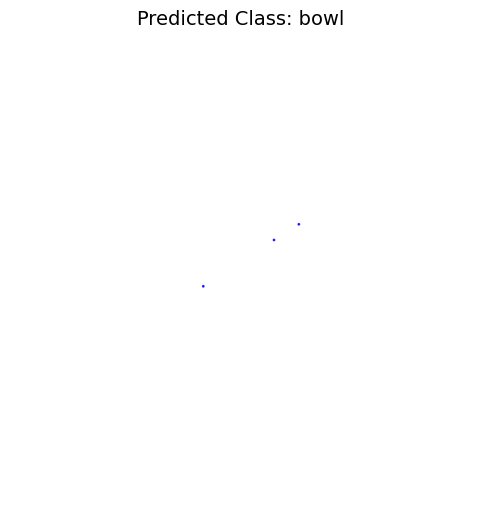

True: bottle, Predicted: vase


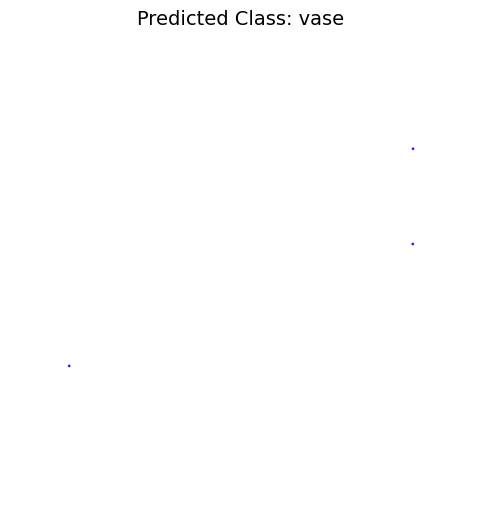

True: piano, Predicted: piano


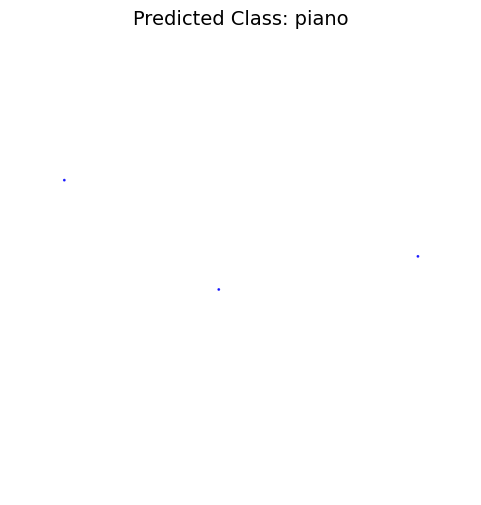

True: toilet, Predicted: toilet


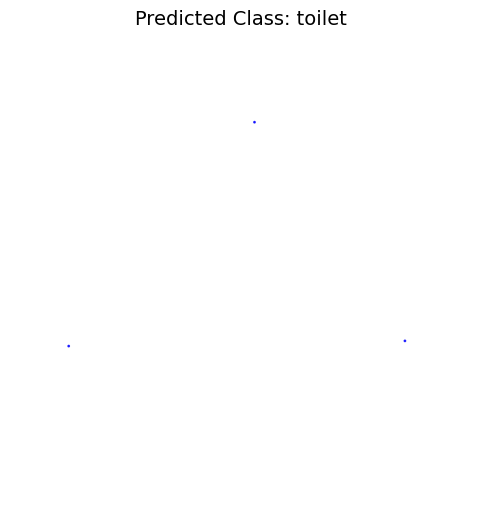

True: bed, Predicted: bed


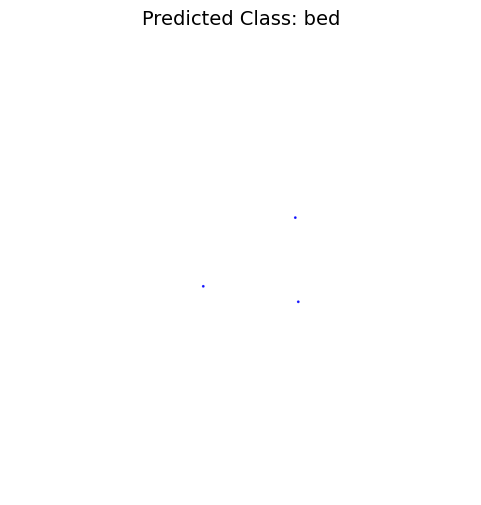

In [28]:
idx_to_class = {i: label for i, label in enumerate(label_encoder.classes_)}

model.eval()
with torch.no_grad():
    for i in range(5):
        points, true_label = val_dataset[i]
        input_points = points.unsqueeze(0).to(device)
        outputs, _ = model(input_points)
        pred_label_idx = outputs.argmax(dim=1).item()
        pred_label_name = idx_to_class[pred_label_idx]
        true_label_name = idx_to_class[true_label.item()]
        
        print(f"True: {true_label_name}, Predicted: {pred_label_name}")
        
        points_np = np.array(points.cpu().tolist())
        visualize_point_cloud_matplotlib(points_np, pred_label_name)

Evaluating: 100%|██████████| 44/44 [00:01<00:00, 24.10it/s]



Evaluation Results
Overall Accuracy (OA):    84.84%
Mean Class Accuracy (mAcc): 75.91%


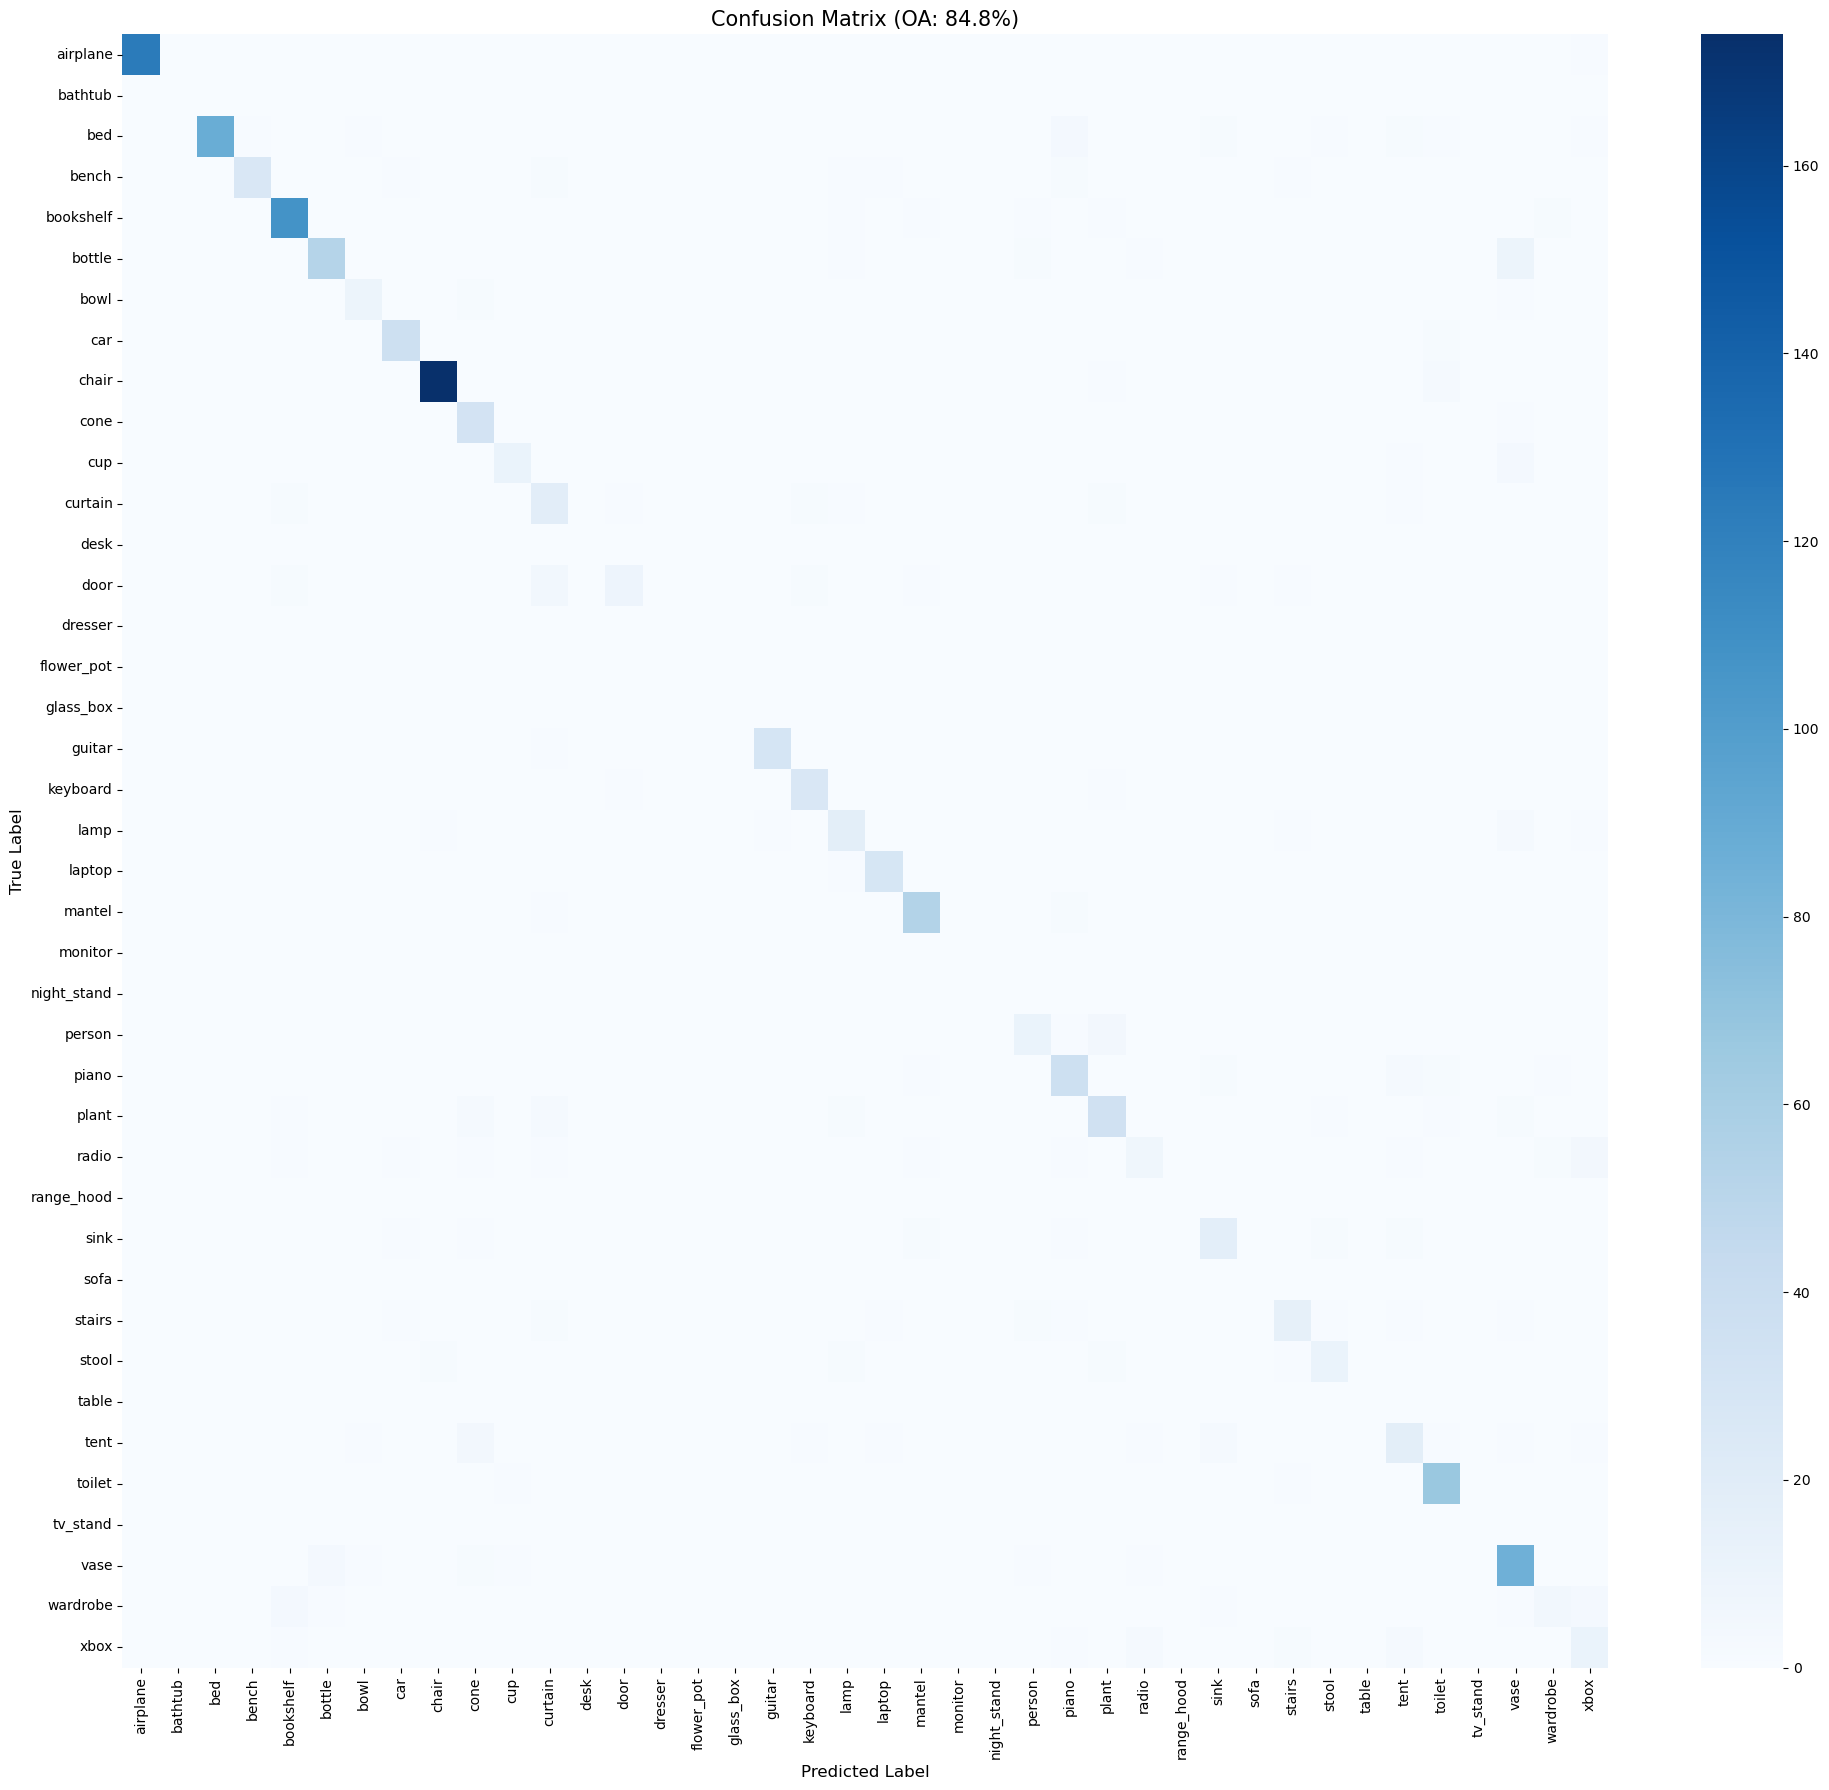


🔍 Detailed Classification Report:
              precision    recall  f1-score   support

    airplane     1.0000    0.9920    0.9960       125
     bathtub     0.0000    0.0000    0.0000         0
         bed     1.0000    0.8713    0.9312       101
       bench     0.9643    0.7714    0.8571        35
   bookshelf     0.9076    0.9474    0.9270       114
      bottle     0.9138    0.7910    0.8480        67
        bowl     0.7692    0.7692    0.7692        13
         car     0.9024    0.9487    0.9250        39
       chair     0.9831    0.9775    0.9803       178
        cone     0.6957    0.9697    0.8101        33
         cup     0.8462    0.6875    0.7586        16
     curtain     0.5429    0.6786    0.6032        28
        desk     0.0000    0.0000    0.0000         0
        door     0.8182    0.4091    0.5455        22
     dresser     0.0000    0.0000    0.0000         0
  flower_pot     0.0000    0.0000    0.0000         0
   glass_box     0.0000    0.0000    0.0000   

In [29]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report
import seaborn as sns



def evaluate_and_plot_stats(model, dataloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for point_clouds, labels in tqdm(dataloader, desc="Evaluating"):
            point_clouds, labels = point_clouds.to(device), labels.to(device)
            
            outputs, _ = model(point_clouds)
            preds = outputs.argmax(dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    num_classes = len(class_names)
    all_class_ids = list(range(num_classes)) 

    oa = accuracy_score(all_labels, all_preds)
    macc = balanced_accuracy_score(all_labels, all_preds)
    
    print(f"\n{'='*30}")
    print(f"Evaluation Results")
    print(f"{'='*30}")
    print(f"Overall Accuracy (OA):    {oa*100:.2f}%")
    print(f"Mean Class Accuracy (mAcc): {macc*100:.2f}%")
    print(f"{'='*30}")

    cm = confusion_matrix(all_labels, all_preds, labels=all_class_ids)
    
    plt.figure(figsize=(20, 18))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title(f'Confusion Matrix (OA: {oa*100:.1f}%)', fontsize=15)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    print("\n🔍 Detailed Classification Report:")
    print(classification_report(all_labels, all_preds, labels=all_class_ids, target_names=class_names, digits=4, zero_division=0))


evaluate_and_plot_stats(model, val_loader, device, class_name)

In [31]:
test_dataset = PCD(test_paths, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Loading 2468 files (Train)...


100%|██████████| 2468/2468 [02:14<00:00, 18.32it/s] 


Evaluating: 100%|██████████| 49/49 [00:02<00:00, 22.06it/s]



Evaluation Results
Overall Accuracy (OA):    85.00%
Mean Class Accuracy (mAcc): 75.07%


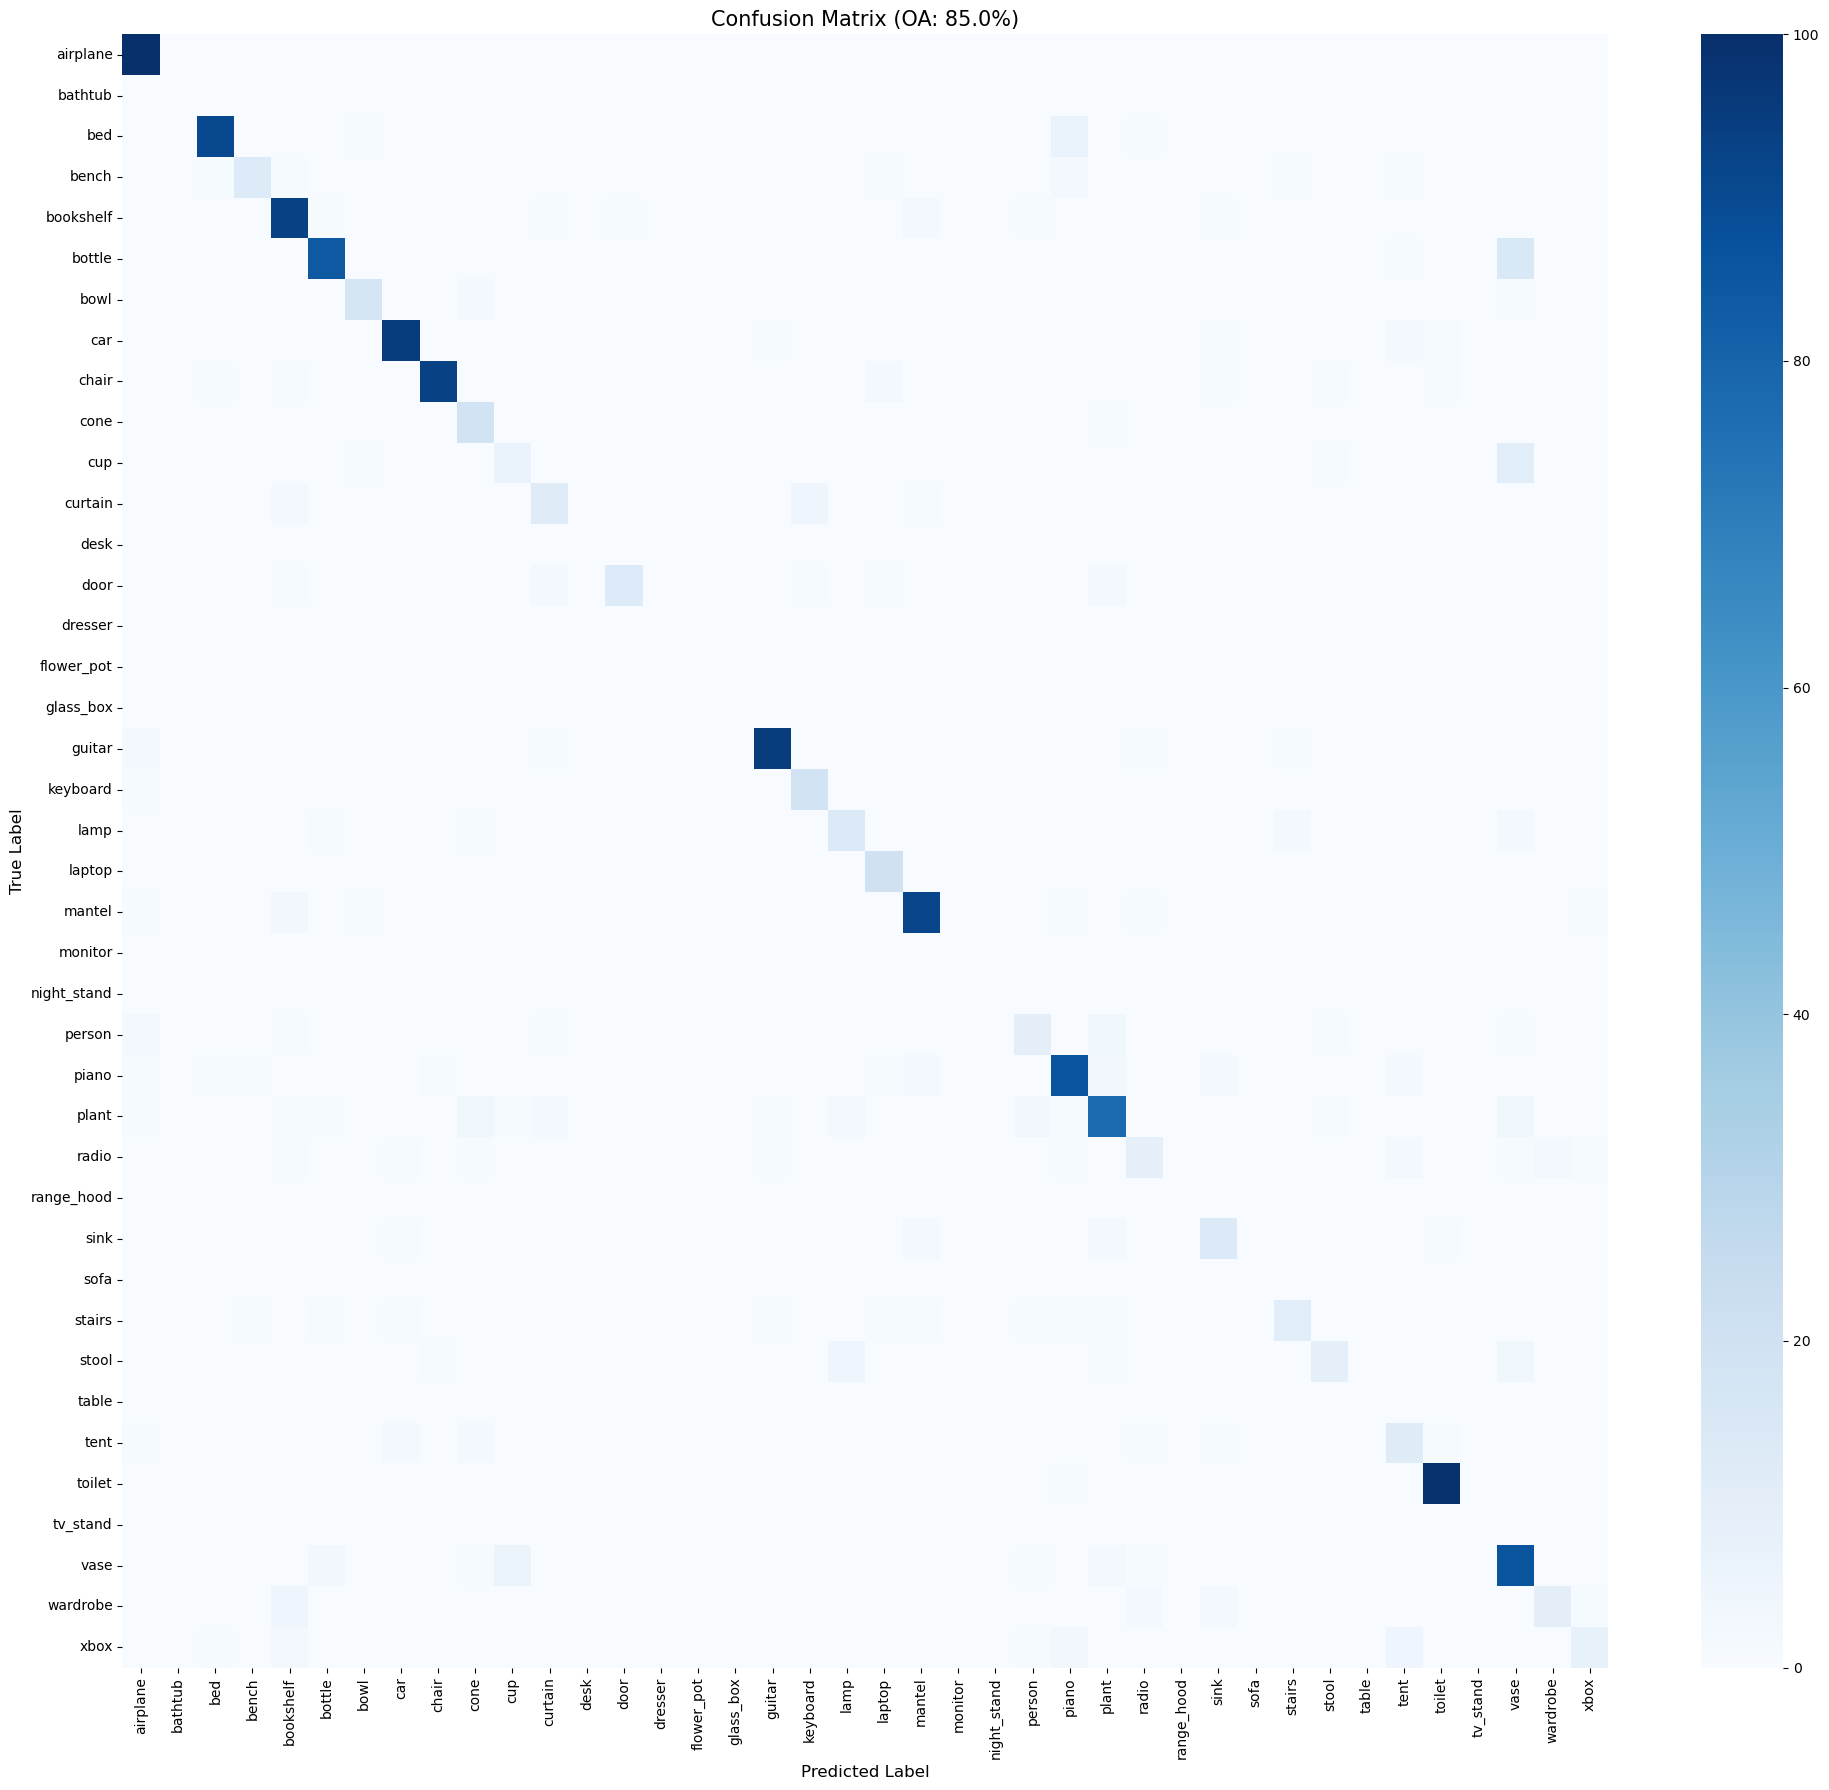


🔍 Detailed Classification Report:
              precision    recall  f1-score   support

    airplane     0.9174    1.0000    0.9569       100
     bathtub     0.0000    0.0000    0.0000         0
         bed     0.9579    0.9100    0.9333       100
       bench     0.8667    0.6500    0.7429        20
   bookshelf     0.8378    0.9300    0.8815       100
      bottle     0.9231    0.8400    0.8796       100
        bowl     0.8500    0.8500    0.8500        20
         car     0.9500    0.9500    0.9500       100
       chair     0.9789    0.9300    0.9538       100
        cone     0.6333    0.9500    0.7600        20
         cup     0.5000    0.3500    0.4118        20
     curtain     0.6316    0.6000    0.6154        20
        desk     0.0000    0.0000    0.0000         0
        door     0.9286    0.6500    0.7647        20
     dresser     0.0000    0.0000    0.0000         0
  flower_pot     0.0000    0.0000    0.0000         0
   glass_box     0.0000    0.0000    0.0000   

In [32]:
evaluate_and_plot_stats(model, test_loader, device, class_name)